## Usage
Like a regular notebook:
- __run a cell__ with **_ctrl-enter_** or **_shift-enter_**
- __use the command palette__ with **_ctrl-shift-P_** to find more complex commands

Use it only with __Chrome__


In [0]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Session 1

This introduction will altern theory & practice, and will be divided as follow:
0. Data Exploration 
1. Problematic 
2. From Text to numbers
    1. From one text to a list of tokens 
    2. From a list of tokens to an embedding 
3. Modelling 
    1. Baseline model 
    2. Logistic Regression
4. Neural Network
    1. Architecture 
    2. Parameters and initialization 
    3. Activation functions  
    4. Forward propagation  
    5. Measuring progress
    6. Computing gradients with backpropagation
    7. Updating parameters - teaching
    8. Assembling bricks - training
    9. Let’s try
        1. Archi 1
        2. Archi 2

## 0. Data exploration

Let's download datasets

In [0]:
def download_data():
    import urllib.request
    import os
    folder = './data'
    list_urls = [
        ('https://bendrive.s3-eu-west-1.amazonaws.com/test_set.csv', 'test_set.csv'),
        ('https://bendrive.s3-eu-west-1.amazonaws.com/test_set_with_rating.csv', 'test_set_with_rating.csv'),
        ('https://bendrive.s3-eu-west-1.amazonaws.com/train_set.csv', 'train_set.csv')
        
    ]
    if not os.path.isdir(folder):
        os.mkdir(folder)
    for url, file in list_urls:
        if not os.path.isfile(folder + '/' + file):
            print("Downloading .. ", file)
            urllib.request.urlretrieve(url, folder + '/' + file)

download_data()

With pandas, load the datasets into dataframes

In [0]:
import pandas as pd


df_test_w_rating = pd.read_csv("./data/test_set_with_rating.csv")
df_test = pd.read_csv("./data/test_set.csv")
df_train = pd.read_csv("./data/train_set.csv")

Load only a part of the train data for convenience

In [0]:
df_train = df_train[0:30000]
df_train.head(1)

,review,rating,user_id,business_id,useful_review,funny_review,cool_review,name_restaurant,address,city,state,postal_code,latitude,longitude,review_count_restaurant,is_open,name_user,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_photos
0,"Like walking back in time, every Saturday morn...",4.0,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,0.0,0.0,0.0,Pinball Hall Of Fame,1610 E Tropicana Ave,Las Vegas,NV,89119.0,36.101449,-115.130511,1258.0,1.0,Carol,866.0,2010-08-26 22:09:14,1635.0,314.0,726.0,"2011,2012,2013,2014,2015,2016,2017,2018",63.0,4.16,18.0,10.0,3.0,2.0,2.0,29.0,26.0,53.0,53.0,15.0


We will focus on review and rating

In [0]:
pd.set_option('display.max_colwidth', -1)

df_train = df_train[['review', 'rating']].dropna()
df_train['rating'] = df_train['rating'].astype('int')

# Show a good review
print("GOOD REVIEW")
display(df_train[df_train['rating']==5].sample(1))

# Show a bad review
print("BAD REVIEW")
display(df_train[df_train['rating']==1].sample(1))

GOOD REVIEW


,review,rating
12073,"Excellent food!!!!! Masala Dosa is legit!!! Don't believe the other reviews... this is so good, flavors are on point and just spicy enough!",5


BAD REVIEW


,review,rating
3657,"The guy who took my order was really rude. It was my first time going there so I guess I didn't order quick enough or I wasn't an expert in whatever I was ordering. I wanted a mixed berry smoothie at first and the guy had the nerve to roll his eyes in my face and tell me he just didn't have yogurt or whatever to make it. Then I was like ok, I want a caramel macchiato. He mumbled something under his breath, so thinking that he couldn't make it, I started to say ""ok then I'll have something else."" He bit back with ""NO! Do you want iced or heated?!"" I said iced. I also wanted a bagel; I looked him straight in the eyes and ordered my bagel while he was gossiping with someone else and he never gave me my bagel xS, never even processed that I had ordered something else. Not going back there again.",1


Let's look at the number of comments for each rating

In [0]:
print(df_train['rating'].value_counts())
print(df_train['rating'].value_counts(normalize=True))

5    12483
4    7372 
3    3972 
1    3498 
2    2669 
Name: rating, dtype: int64
5    0.416183
4    0.245782
3    0.132426
1    0.116623
2    0.088984
Name: rating, dtype: float64


Let's look at the distribution in a more convenient way

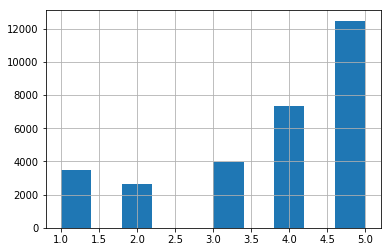

In [0]:
%matplotlib inline

df_train["rating"].hist()

# 1. Problematic

Are we able to predict the rating from the text comment ?

So our goal is to have a model, a function, that takes text as input and output a rating.

$f(text) = rating$

Are **you** able to do it ?

In [0]:
# Show a bad review
import numpy as np

print("GUESS THE RATING ?")
random_rating = np.random.randint(1, 6)
display(df_train[df_train['rating']==random_rating]['review'].sample(1))

GUESS THE RATING ?


28377    The vibe is good and the staff is friendly but the food is mediocre. We ordered the brisket nachos but the meat had no flavor. The jalapenos were freshly sliced and the tomatoes are fresh but you have to pick up each ingredient and place it on a chip in order to build a chip with any flavor. It was an interesting display when serving the food but beyond the initial novelty, the taste is just not there.
Name: review, dtype: object

In [0]:
print(random_rating)

2


To begin with a binary classification problem, we will bin the target into bad review and good review

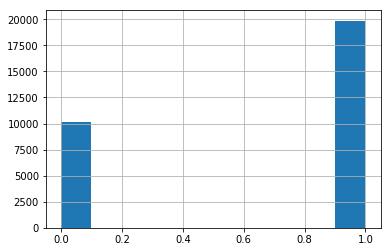

In [0]:
df_train['bin_rating'] = df_train['rating'].apply(lambda x: 1 if x > 3 else 0)

df_train["bin_rating"].hist()

# 2. From text to numbers

First step is to transform text into numbers, to go from:

    f(text) = rating

to

    f(numerical_vector_representing_text) = rating

For example:

    "Meh.  Nothing special.  Food was just ok."

must be transformed to something like:

    [0, 4, 2, 8]

where the values of the vector convey meaning of the text. Two different texts must have a different representation:

    "Meh.  Nothing special.  Food was just ok." > [0, 4, 2, 8]
    
    "Aww.  Spectacular.  Food was amaaaaazing." > [4, 2, 6, 1]

Also, it would be more convenient if texts of different sizes can translate to a fixed size vector, for example:

    "Meh.  Nothing special.  Food was just ok." > [0, 4, 2, 8]
    
    "Meh." > [0, 3, 3, 7]


## 2.1 From one text to a list of tokens

First step is to convert a text, which is one string of characters, to a list of words.

    "Meh.  Nothing special." > ["meh", "nothing", "special"]
    
Then, those words must be transformed into tokens, wich are representation of words. This can be done with

(1) **Stemming** is the process of eliminating affixes (suffixed, prefixes, infixes, circumfixes) from a word in order to obtain a word stem.

(2) **Lemmatization** is related to stemming, differing in that lemmatization is able to capture canonical forms based on a word's lemma.

(3) **Everything else**: set all characters to **lowercase**, remove numbers (or convert numbers to textual representations), remove **punctuation** (generally part of tokenization, but still worth keeping in mind at this stage, even as confirmation), strip white space (also generally part of tokenization), remove default  **stop words**  (general English stop words), etc.

In [0]:
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    return df
    
def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df

def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    return df

def remove_stop_words(df, colname):
    stop_words = stopwords.words('english')
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in stop_words])
    return df

def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    return df


def text_cleaning(df, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters '\n'
    3. Tokenize sentences
    4. Remove all stopwords
    5. convert tokenized text to text
    """
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df

- clean the review column

In [0]:
df_cleaned = text_cleaning(df_train, 'review')

df_cleaned.sample(1)

,review,rating,bin_rating
17799,greenberg gets full five stars book yes know authentic jewish deli foods pretty close especially given casino las vegas reuben world similar reuben 1/2 pound larger carnegie deli new york 24 reuben 10 nearly good stop brisket turkey meats good pickles mustards whole nine yards n none additional open breakfast hours full menu available nice also 5 95 deal either bacon egg cheese croissant pastrami egg bagel coupled large coffee good deal croissant huge n nreally like place especially compare areas nearby 10 ok crepe 6 00 so-so slice pizza etc good food good value,5,1


## 2.2. From a list of tokens to an embedding (numerical vector)

We still have to transform the list of tokens to a fixed size numerical vector

    ["meh", "nothing", "special"] > [0, 2, 8, 1]
    ["my", "belly", "is", "happy"] > [2, 1, 9, 3]
    ["i", "took", "a", "loan", "to", "eat", "there"] > [1, 1, 3, 8]

For that, we will use a very common technique called TF-IDF

**Definition**

> **TF-IDF** or **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to reflect how important a word is to a document in a collection or corpus.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:  
      
    TF(t) = (Nbr of times term t appears in a document) / (Total nbr of terms in the document)
    
**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:  
      
    IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

_Example:_
_Consider a document containing 100 words wherein the word _cat_ appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word _cat_ appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12._

**Tools**

Python **sklearn** package **feature_extraction**.

In [0]:
number_of_dimensions = 64

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned["review"]).toarray()

In [0]:
randrow = np.random.randint(100)

print(" == Text\n")
print(df_cleaned["review"][randrow])
print("\n == Rating\n")
print(df_cleaned["rating"][randrow])
print("\n == Embedding\n")
print(X_tfidf[randrow])

 == Text

went last weekend pretty disappointed one thing pictured recommended yelp good started steak grilled skewers ok nothing special freind got lasagna got special chicken dish pretty bland lacking kick waitress really nice got manger switch dishes freind got hamburger got shrimp scampi hamburger better lasagna still lacking flavor scampi better chicken also still seasoned noodles bit cooked big name attached restaurant going empty stomach high hopes service great gave three stars

 == Rating

2

 == Embedding

[0.14294182 0.         0.         0.         0.         0.
 0.32447549 0.         0.         0.         0.30544986 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.09921426 0.73213226 0.1089112  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.14805736 0.         0.
 0.12663703 0.         0.         0.         0.         0.
 0.328

## 3. Modelling

Yeah ! We now have a numerical representation of the text, and the rating associated. Remember we start with a binary classification task: bad review / good review.

#### Split data into train / test sets

In order to measure the performance of our modeling, we need to split the data into:

- The **training set** contains a known output and the model learns on this data in order to be generalized to other data later on (= 80%)

- We have the **test set** in order to test our model’s prediction on this test set (= 20%)

In [0]:
TARGET = 'bin_rating'
FEATURE = 'review'

x_train, x_test, y_train, y_test = train_test_split(
    df_cleaned[FEATURE], 
    df_cleaned[TARGET], 
    test_size=0.2,
    random_state=2019)

## 3.1 Baseline model

As a baseline model, let's use a random model with a probability of good/bad review based on the distribution of the train set.

In [0]:
y_pred_baseline = np.random.choice(
    [0, 1],
    size=len(y_test),
    p=[1-y_train.mean(), y_train.mean()])

We need now to evaluate our baseline model.

- **True Positives** (TP): these are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. *E.g. if actual class value indicates that this passenger survived and predicted class tells you the same thing.*

- **True Negatives** (TN): these are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. *E.g. if actual class says this passenger did not survive and predicted class tells you the same thing.*

*False positives and false negatives, these values occur when your actual class contradicts with the predicted class.*

- **False Positives** (FP): when actual class is no and predicted class is yes. *E.g. if actual class says this passenger did not survive but predicted class tells you that this passenger will survive.*

- **False Negatives** (FN): when actual class is yes but predicted class in no. *E.g. if actual class value indicates that this passenger survived and predicted class tells you that passenger will die.*

- **Accuracy**: Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model.

> Accuracy = TP+TN/TP+FP+FN+TN

*= 154656 + 68551 / 154656 + 14186 + 9438 +68551 = 0.90*

- **Precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate.

> Precision = TP/TP+FP

*= 154656 / 154656 + 14186 = 0.92*

- **Recall (Sensitivity)**: Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label?

> Recall = TP/TP+FN

*= 154656 / 154656 + 9438 = 0.94*

- **F1 score**: F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

> F1 Score = 2*(Recall * Precision) / (Recall + Precision)

*= 2 * (0.94 * 0.92) / (0.94 + 0.92) = 0.93*

In [0]:
confusion_matrix(y_test, y_pred_baseline, labels=None, sample_weight=None)

array([[ 631, 1370],
       [1299, 2699]])

In [0]:
print('accuracy {}'.format(accuracy_score(y_pred_baseline, y_test)))
print(classification_report(y_test, y_pred_baseline))

accuracy 0.5550925154192365
              precision    recall  f1-score   support

           0       0.33      0.32      0.32      2001
           1       0.66      0.68      0.67      3998

    accuracy                           0.56      5999
   macro avg       0.50      0.50      0.50      5999
weighted avg       0.55      0.56      0.55      5999



## 3.2 Logistic Regression

We can do better than a random model with logistic regression

#### Fit model

In [0]:
logit = LogisticRegression(solver='lbfgs', verbose=2, n_jobs=-1)

pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('model', logit)])

pipeline.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=64,
                                 min_df=10, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_s

#### Predictions

In [0]:
y_pred = pipeline.predict(x_test)

In [0]:
confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

array([[1205,  796],
       [ 545, 3453]])

In [0]:
print('accuracy {}'.format(accuracy_score(y_pred, y_test)))
print(classification_report(y_test, y_pred))

accuracy 0.7764627437906317
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      2001
           1       0.81      0.86      0.84      3998

    accuracy                           0.78      5999
   macro avg       0.75      0.73      0.74      5999
weighted avg       0.77      0.78      0.77      5999



Fortunately, logistic regression can do better than a random model.

# 4. Neural Network

## 4.1. Architecture

Now, let's try to design a neural network model for our task.

* What would be the input layer size ?
* What would be the output layer size ?
* What would be the output layer activation function ?

We store the architecture of the neural network in a list of dictionnaries

In [0]:
NN_ARCHITECTURE_0 = [
    {"input_dim": number_of_dimensions, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

NN_ARCHITECTURE_1 = [
    {"input_dim": number_of_dimensions, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

## 4.2. Parameters and initialization

Each neuron has two parameters: weight (W) and bias (b).

Let's initialize those parameters for each neuron and store them in a dictionnary with notation:
* Wi is the array of the weights of the neurons of layer i
* bi is the array of the biases of the neurons of the layer i

In [0]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

params_values = init_layers(NN_ARCHITECTURE_0)

for key, value in params_values.items():
    print(key, value.shape)

W1 (8, 64)
b1 (8, 1)
W2 (4, 8)
b2 (4, 1)
W3 (1, 4)
b3 (1, 1)


## 4.3. Activation functions

What does a neuron do ?

First it computes a value: Z, the linear combination of its inputs A by its weighted coefficients W and add a bias b. Then it applies an activation function to Z, and generates an output A.

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$

$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

So, imagine a network where input layer has 3 neurons (layer 0), and next layer (layer 1) has 2 neurons.

    N00
            N10  
    N01
            N11
    N02

N10 would compute a value, like this:

$$Z^{[10]} = W^{[10-00]} * A^{[00]} + W^{[10-01]} * A^{[01]} + W^{[10-02]} * A^{[02]} + b^{[10]}$$
$$A^{[10]} = g^{[l]}(Z^{[10]})$$

* What is the role of the activation function ?
* Code the activation functions sigmoid and relu

In [0]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

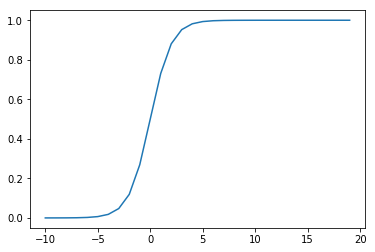

In [0]:
x = np.arange(-10, 20)
plt.plot(x, sigmoid(x))

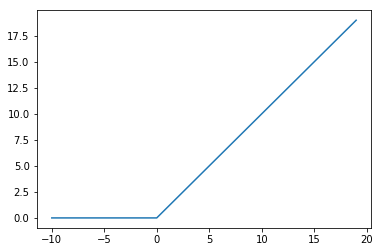

In [0]:
x = np.arange(-10, 20)
plt.plot(x, relu(x))

## 4.3. Forward propagation

Forward propagation of a neural network is the left to right pass. It is the inference of the neural network model: from the input layer, the output layer is computed by forward propagation the value from one neuron to another.

With the stored weights and biases of the neutwork, let's write the forward propagation functions

In [0]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

In [0]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

Let's try with a random observation

In [0]:
random_input = np.random.randn(number_of_dimensions, 1)
output, _ = full_forward_propagation(random_input, params_values, NN_ARCHITECTURE_0)
print("Output value is:", output)

Output value is: [[0.49529866]]


Let's now try with our train data embedding

In [0]:
x_train_features = tfidf_vectorizer.fit_transform(x_train).toarray()
x_train_features.shape

(23995, 64)

In [0]:
output, _ = full_forward_propagation(np.transpose(x_train_features), params_values, NN_ARCHITECTURE_0)
output.shape

(1, 23995)

In [0]:
y_train.shape

(23995,)

So, we are able to infer a neural net to our data ! But are we good ?

In [0]:
print(output[0:10])

[[0.49113446 0.49245251 0.49245251 ... 0.49245251 0.49245251 0.49245251]]


The output is now a proba, we need to convert it to a class.

In [0]:
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [0]:
y_pred_first_inference = convert_prob_into_class(output)
print(y_pred_first_inference[0:10])

[[0. 0. 0. ... 0. 0. 0.]]


So how does it look ?

In [0]:
print('accuracy {}'.format(accuracy_score(np.squeeze(y_pred_first_inference), y_train)))
print(classification_report(np.squeeze(y_pred_first_inference), y_train))

accuracy 0.3391539904146697
              precision    recall  f1-score   support

         0.0       1.00      0.34      0.51     23995
         1.0       0.00      0.00      0.00         0

    accuracy                           0.34     23995
   macro avg       0.50      0.17      0.25     23995
weighted avg       1.00      0.34      0.51     23995



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


BAD !

Wait a minute, we forgot to train the neural network !

## 4.4 Measuring progress

Evaluating with a classification report is nice for the human to understand the model performances. But in order to train the model, we need a simpler and computational measure off the model fitness.

This measure is the **loss**. The loss can be different from the metric that we - as human - use to evaluate the model.

We should routinely calculate the value of the loss function. "Generally speaking, the loss function is designed to show how far we are from the 'ideal' solution." It is selected according to the problem we plan to solve. For binary classification, binary crossentropy is common.

In [0]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

In [0]:
get_cost_value(np.array([[0.3, 0.1, 0.3]]), np.array([[0.1, 0.1, 0.4]]))

array(0.4873606)

In [0]:
get_cost_value(output, y_train)

array(0.69814624)

## 4.5 Computing gradients with backpropagation

Our neural network is dumb, we have been able to compute a loss. Now we need to understand where this loss is coming from, do we have dumber neurons than others ? For that we need to compute the gradient of the loss for each parameter.

For that, we start from the loss at the output layer. We compute the derivatives of each neuron in order to update the weights and we go on until we reach the input layer.

This process is called backpropagation.

In NN, we calculate the gradient of the loss function in respect to parameters, but backpropagation can be used to calculate derivatives of any function. The essence of this algorithm is the recursive use of a chain rule known from differential calculus - calculate a derivative of functions created by assembling other functions, whose derivatives we already know. This process - for one network layer - is described by the following formulas. Looking at the formulas, it becomes obvious why we decided to remember the values of the A and Z matrices for intermediate layers in a forward step.

$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$


So first, we need to compute the derivatives of the activation functions

In [0]:
def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ

Let's backpropagate now

In [0]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [0]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## 4.6 Updating parameters - Teaching

Now that we know the gradient of the loss according to all neurons, we can teach the model, by updating the weights according to their gradients and a given learning rate.

This update parameter is simply done here with gradient descent. More complex optimizers exist.

In [0]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

## 4.7 Assembling bricks - Training

In [0]:
def train(X, Y, nn_architecture, epochs=1000, learning_rate=0.1, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 200 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

## 4.8 Let's try

####  Archi 1

In [0]:
# Training

x_train_features = tfidf_vectorizer.fit_transform(x_train).toarray()

y_train_array = np.array(y_train)

params_values = train(np.transpose(x_train_features),
                      np.transpose(y_train_array.reshape((y_train_array.shape[0], 1))),
                      NN_ARCHITECTURE_0, epochs=10000, learning_rate=0.1,
                      verbose=True
                     )

Iteration: 00000 - cost: 0.69120 - accuracy: 0.66089
Iteration: 00200 - cost: 0.64040 - accuracy: 0.66085
Iteration: 00400 - cost: 0.64035 - accuracy: 0.66085
Iteration: 00600 - cost: 0.64028 - accuracy: 0.66085
Iteration: 00800 - cost: 0.64016 - accuracy: 0.66085
Iteration: 01000 - cost: 0.63994 - accuracy: 0.66085
Iteration: 01200 - cost: 0.63950 - accuracy: 0.66085
Iteration: 01400 - cost: 0.63850 - accuracy: 0.66085
Iteration: 01600 - cost: 0.63565 - accuracy: 0.66085
Iteration: 01800 - cost: 0.62524 - accuracy: 0.66085
Iteration: 02000 - cost: 0.58357 - accuracy: 0.67122
Iteration: 02200 - cost: 0.51381 - accuracy: 0.76037
Iteration: 02400 - cost: 0.48476 - accuracy: 0.76829
Iteration: 02600 - cost: 0.47759 - accuracy: 0.77224
Iteration: 02800 - cost: 0.47555 - accuracy: 0.77312
Iteration: 03000 - cost: 0.47480 - accuracy: 0.77308
Iteration: 03200 - cost: 0.47447 - accuracy: 0.77362
Iteration: 03400 - cost: 0.47429 - accuracy: 0.77337
Iteration: 03600 - cost: 0.47420 - accuracy: 0

In [0]:
x_test_features = tfidf_vectorizer.fit_transform(x_test).toarray()

y_test_array = np.array(y_test)

output, _ = full_forward_propagation(np.transpose(x_test_features),
                                     params_values,
                                     NN_ARCHITECTURE_0)
y_pred_architecture_0 = convert_prob_into_class(output)

print('accuracy {}'.format(accuracy_score(np.squeeze(y_pred_architecture_0), y_test)))
print(classification_report(np.squeeze(y_pred_architecture_0), y_test))

accuracy 0.7132855475912652
              precision    recall  f1-score   support

         0.0       0.53      0.58      0.55      1837
         1.0       0.81      0.77      0.79      4162

    accuracy                           0.71      5999
   macro avg       0.67      0.68      0.67      5999
weighted avg       0.72      0.71      0.72      5999



####  Archi 2

In [0]:
# Training

x_train_features = tfidf_vectorizer.fit_transform(x_train).toarray()

y_train_array = np.array(y_train)

params_values_1 = train(np.transpose(x_train_features),
                      np.transpose(y_train_array.reshape((y_train_array.shape[0], 1))),
                      NN_ARCHITECTURE_1, epochs=10000, learning_rate=0.1,
                      verbose=True
                     )

Iteration: 00000 - cost: 0.70041 - accuracy: 0.33915
Iteration: 00200 - cost: 0.64046 - accuracy: 0.66085
Iteration: 00400 - cost: 0.64045 - accuracy: 0.66085
Iteration: 00600 - cost: 0.64044 - accuracy: 0.66085
Iteration: 00800 - cost: 0.64043 - accuracy: 0.66085
Iteration: 01000 - cost: 0.64042 - accuracy: 0.66085
Iteration: 01200 - cost: 0.64041 - accuracy: 0.66085
Iteration: 01400 - cost: 0.64039 - accuracy: 0.66085
Iteration: 01600 - cost: 0.64037 - accuracy: 0.66085
Iteration: 01800 - cost: 0.64034 - accuracy: 0.66085
Iteration: 02000 - cost: 0.64030 - accuracy: 0.66085
Iteration: 02200 - cost: 0.64024 - accuracy: 0.66085
Iteration: 02400 - cost: 0.64017 - accuracy: 0.66085
Iteration: 02600 - cost: 0.64005 - accuracy: 0.66085
Iteration: 02800 - cost: 0.63988 - accuracy: 0.66085
Iteration: 03000 - cost: 0.63959 - accuracy: 0.66085
Iteration: 03200 - cost: 0.63903 - accuracy: 0.66085
Iteration: 03400 - cost: 0.63770 - accuracy: 0.66085
Iteration: 03600 - cost: 0.63298 - accuracy: 0

In [0]:
x_test_features = tfidf_vectorizer.fit_transform(x_test).toarray()

y_test_array = np.array(y_test)

output, _ = full_forward_propagation(np.transpose(x_test_features),
                                     params_values_1,
                                     NN_ARCHITECTURE_1)
y_pred_architecture_1 = convert_prob_into_class(output)

print('accuracy {}'.format(accuracy_score(np.squeeze(y_pred_architecture_1), y_test)))
print(classification_report(np.squeeze(y_pred_architecture_1), y_test))

accuracy 0.7202867144524088
              precision    recall  f1-score   support

         0.0       0.42      0.62      0.50      1341
         1.0       0.87      0.75      0.81      4658

    accuracy                           0.72      5999
   macro avg       0.64      0.68      0.65      5999
weighted avg       0.77      0.72      0.74      5999

